# Link Prediction in Networks

In [1]:
import math
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from matplotlib_venn import venn2
from tqdm.auto import tqdm

import data_utils
import graph_utils
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc

Let's take a look at the anonymized network that was generated using email data from a large European research institution [[REF](https://snap.stanford.edu/data/email-Eu-core-temporal.html)]. In the original dataset, a directed edge (u, v, t) means that person u sent an email to person v at time t. A separate edge is created for each recipient of the email. We will aggregate the data and convert it into a non-directional graph.

In [2]:
# Load dataset
df_edges_raw = data_utils.load_dataset_from_web(
    "email-Eu-core-temporal.txt.gz", sep=" "
)
df_edges_raw.columns = ["source", "target", "ts_seconds"]
df_edges_raw["ts_days"] = df_edges_raw["ts_seconds"] // (24 * 3600)

# Generate dataframe with weight and first_ts
df_edges = (
    df_edges_raw.groupby(["source", "target"])
    .agg(first_day=("ts_days", "min"), weight=("ts_days", "count"))
    .reset_index()
    .sort_values("first_day")
)

print(
    f"The dataset contains {df_edges.shape[0]:,} directional edges that span {df_edges['first_day'].max()} days."
)
df_edges.head()

The dataset contains 24,929 directional edges that span 802 days.


,source,target,first_day,weight
14253,569,295,0,69
9513,360,561,0,2
18109,724,246,0,106
14201,568,379,0,107
24468,987,641,0,313


In [3]:
# Convert to non-directional edges
df_non_directed_edges = df_edges.copy()
df_non_directed_edges["source"], df_non_directed_edges["target"] = np.minimum(
    df_edges["source"], df_edges["target"]
), np.maximum(df_edges["source"], df_edges["target"])

df_non_directed_edges = (
    df_non_directed_edges.groupby(["source", "target"])
    .agg(weight=("weight", "sum"), first_day=("first_day", "min"))
    .reset_index()
    .sort_values("first_day")
)

print(
    f'The dataset contains {df_non_directed_edges.shape[0]:,} non-directional edges that span {df_non_directed_edges["first_day"].max()} days.'
)
df_non_directed_edges

The dataset contains 16,064 non-directional edges that span 802 days.


,source,target,weight,first_day
13081,568,947,97,0
9425,335,980,78,0
9426,335,985,26,0
5385,168,260,816,0
9427,335,1004,39,0
...,...,...,...,...
3530,112,425,1,802
5852,185,416,1,802
13959,633,873,1,802
5718,179,789,1,802


In [4]:
# Create social graph before cutoff day
day_cutoff = 365
df_non_directed_edges_before = df_non_directed_edges[
    df_non_directed_edges["first_day"] < day_cutoff
]
social_graph_before = nx.from_pandas_edgelist(
    df_non_directed_edges_before, edge_attr=True
)

perc_before_cutoff = (
    df_non_directed_edges_before.shape[0] / df_non_directed_edges.shape[0] * 100
)
print(
    f"The social graph contains {social_graph_before.number_of_nodes():,} nodes and {social_graph_before.number_of_edges():,} edges. {perc_before_cutoff:.2f}% of the edges are before the cutoff day {day_cutoff}."
)

The social graph contains 891 nodes and 12,457 edges. 77.55% of the edges are before the cutoff day 365.


## Predicting links

At this point, we have a social graph based on the first one year of email data. We can use this graph to predict future links.  


In [5]:
newly_added_edges = df_non_directed_edges[
    df_non_directed_edges["first_day"] >= day_cutoff
]
# only consider nodes that are present in the social graph before the cutoff day
newly_added_edges = newly_added_edges[
    newly_added_edges["source"].isin(social_graph_before.nodes())
    & newly_added_edges["target"].isin(social_graph_before.nodes())
]
print(
    f"The dataset contains {newly_added_edges.shape[0]:,} non-directional edges that were added after the cutoff day {day_cutoff}."
)

The dataset contains 2,755 non-directional edges that were added after the cutoff day 365.



The problem of predicting links in a network is a binary classification problem. Given a network and a set of nodes, we want to predict whether there is a link between each pair of nodes. 

We will use triad-based features that we saw in the previous session. We will also use other, simpler to compute features such as the Jaccard coefficient, Adamic-Adar index, preferential attachment, common neighbors, and resource allocation index.

### Using triad-based features

In [6]:
from importlib import reload
reload(graph_utils)

<module 'graph_utils' from '/Users/boris/Documents/teaching/ML on graphs/MLConnectedWorld/graph_utils.py'>

In [7]:
# df_triad_metrics = graph_utils.triadic_metrics_undirected(social_graph_before)
# this is a very slow operation: on my computer it takes about one hour to compute the triadic metrics
# we will use the precomputed metrics instead
dataset = data_utils.load_dataset_from_local("link_prediction_data")
social_graph_before = dataset["graph"]
newly_added_edges = dataset["future_edges"]
df_triad_metrics = dataset["triad_metrics"]

 We can use the following features, specifically designed for this problem:

- jaccard_coefficient: The Jaccard coefficient is a measure of similarity between two sets. In the context of networks, it is the number of common neighbors between two nodes divided by the total number of neighbors.
- adamic_adar_index: The Adamic-Adar index is a measure of similarity between two nodes based on the number of common neighbors. It is similar to the Jaccard coefficient but assigns more weight to rare neighbors.
- preferential_attachment: The preferential attachment score is the product of the degrees of the two nodes. It assumes that nodes with higher degrees are more likely to form new links.
- common_neighbors: The number of common neighbors between two nodes.
- resource_allocation_index: The resource allocation index is a measure of similarity between two nodes based on the number of common neighbors. It assigns more weight to rare neighbors.

Let's pick up a random(ish) subgraph from our social graph and use it to demonstrate how the above features are calculated.

Graph with 348 nodes and 6077 edges


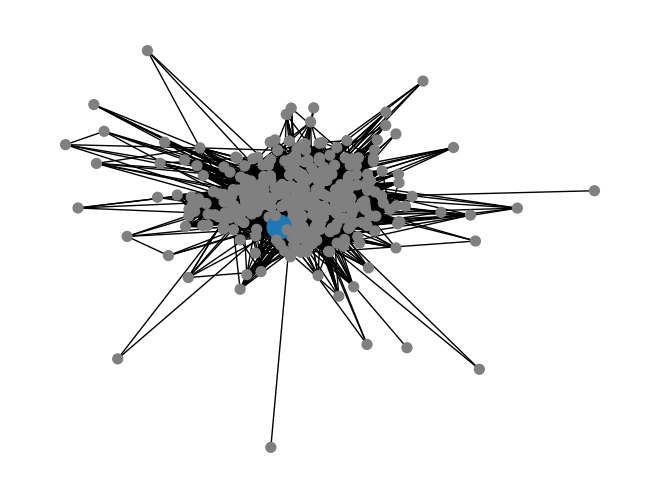

In [8]:
node = 401
g_subgraph = nx.ego_graph(social_graph_before, node, radius=2)
node_size = [300 if n == node else 50 for n in g_subgraph.nodes()]
node_color = ["C0" if n == node else "gray" for n in g_subgraph.nodes()]
# pos = nx.layout.kamada_kawai_layout(g_ego)
pos = nx.layout.spring_layout(g_subgraph)
nx.draw(g_subgraph, with_labels=False, pos=pos, node_size=node_size, node_color=node_color)
print(g_subgraph)

### Other link prediction features

#### Jaccard coefficient

Jaccard coefficient is a measure of similarity between two sets. In the context of networks, it is the number of common neighbors between two nodes divided by the total number of neighbors. In the context of link prediction, it is a measure of how similar the neighborhoods of two nodes are.

Text(0.5, 1.0, 'Jaccard coefficient: 0.024')

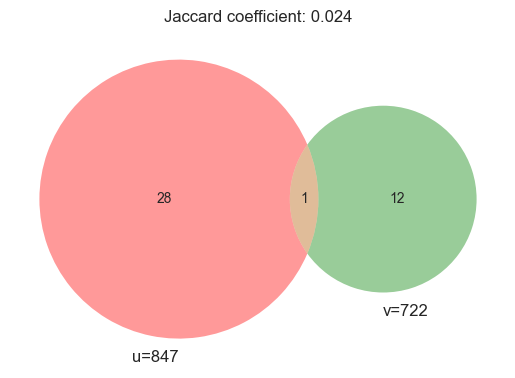

In [9]:
subgraph_nodes = list(g_subgraph.nodes())
u = np.random.choice(subgraph_nodes)
v = np.random.choice(subgraph_nodes)

u_neighbors = set(g_subgraph.neighbors(u))
v_neighbors = set(g_subgraph.neighbors(v))
u_common_neighbors = u_neighbors.intersection(v_neighbors)
venn2([u_neighbors, v_neighbors], set_labels=(f"{u=}", f"{v=}"))
jaccard_coefficient = len(u_common_neighbors) / len(u_neighbors.union(v_neighbors))
plt.title(f"Jaccard coefficient: {jaccard_coefficient:.3f}")

#### Adamic-Adar index

The Adamic-Adar index is a measure of similarity between two nodes based on the number of common neighbors. It is similar to the Jaccard coefficient but assigns more weight to rare neighbors. The Adamic-Adar index is defined as the sum of the inverse logarithm of the degrees of the common neighbors.

Text(0.5, 1.0, 'Adamic-Adar index: 5.645\nJaccard coefficient: 0.119')

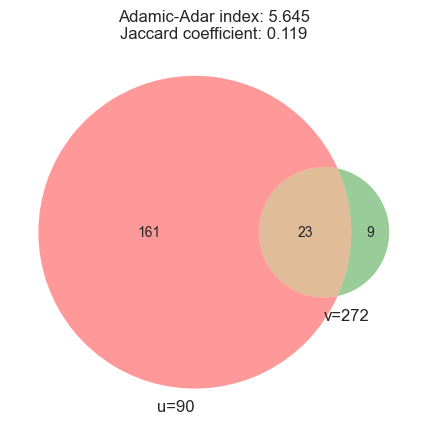

In [10]:
u = np.random.choice(subgraph_nodes)
v = np.random.choice(subgraph_nodes)

u_neighbors = set(g_subgraph.neighbors(u))
v_neighbors = set(g_subgraph.neighbors(v))
u_common_neighbors = u_neighbors.intersection(v_neighbors)
venn2([u_neighbors, v_neighbors], set_labels=(f"{u=}", f"{v=}"))
adamic_adar_index = sum(1 / math.log(g_subgraph.degree(n)) for n in u_common_neighbors)
jaccard_coefficient = len(u_common_neighbors) / len(u_neighbors.union(v_neighbors))
plt.title(
    f"Adamic-Adar index: {adamic_adar_index:.3f}\nJaccard coefficient: {jaccard_coefficient:.3f}"
)

In [11]:
def draw_ego_graph(ax, pos, g, u, v, node_color_main, edge_color_main):
    ego_u = nx.ego_graph(g, u, radius=1)
    ego_v = nx.ego_graph(g, v, radius=1)
    ego = nx.compose(ego_u, ego_v)
    node_color = [node_color_main if n in (u, v) else "gray" for n in ego.nodes()]
    node_size = [100 if n in (u, v) else 50 for n in ego.nodes()]
    node_alpha = [1 if n in (u, v) else 0.2 for n in ego.nodes()]
    edge_color = [
        edge_color_main if e in {(u, v), (v, u)} else "gray" for e in ego.edges()
    ]
    edge_width = [3 if e in {(u, v), (v, u)} else 1 for e in ego.edges()]
    edge_alpha = [1 if e in {(u, v), (v, u)} else 0.1 for e in ego.edges()]

    nx.draw_networkx_edges(
        ego, pos, edge_color=edge_color, width=edge_width, alpha=edge_alpha, ax=ax
    )
    nx.draw_networkx_nodes(
        ego, pos, node_color=node_color, node_size=node_size, alpha=node_alpha, ax=ax
    )


def draw_graphs(g, df_metrics, ax_max_j, ax_max_a):
    """
    Draw subgraphs highlighting specific nodes and edges based on given metrics.

    Args:
        g (networkx.Graph): The input graph.
        df_metrics (pandas.DataFrame): DataFrame containing the nodes and their respective metrics.
        ax_max_j (matplotlib.axes._subplots.AxesSubplot): Axis for the Jaccard coefficient plot.
        ax_max_a (matplotlib.axes._subplots.AxesSubplot): Axis for the Adamic-Adar index plot.

    """
    pos = nx.layout.spring_layout(g)

    u_j, v_j = df_metrics.iloc[max_j][["u", "v"]]
    draw_ego_graph(
        ax=ax_max_j,
        pos=pos,
        g=g,
        u=u_j,
        v=v_j,
        node_color_main="C1",
        edge_color_main="C1",
    )
    u_a, v_a = df_metrics.iloc[max_a][["u", "v"]]
    draw_ego_graph(
        ax=ax_max_a,
        pos=pos,
        g=g,
        u=u_a,
        v=v_a,
        node_color_main="C2",
        edge_color_main="C2",
    )

Text(0.5, 1.0, 'Adamic-Adar index')

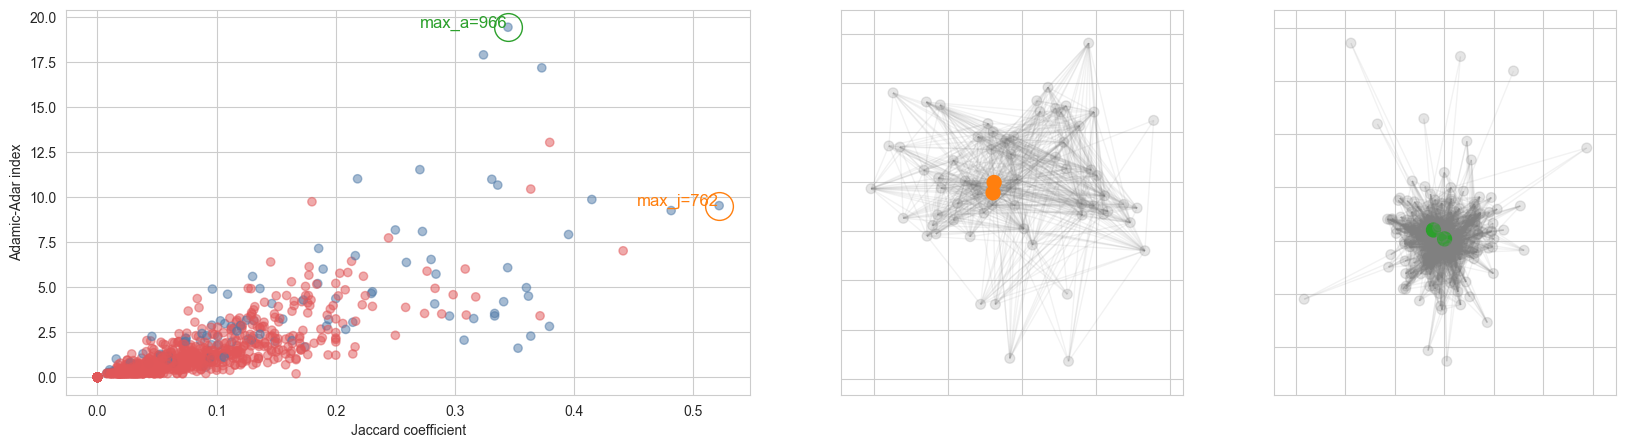

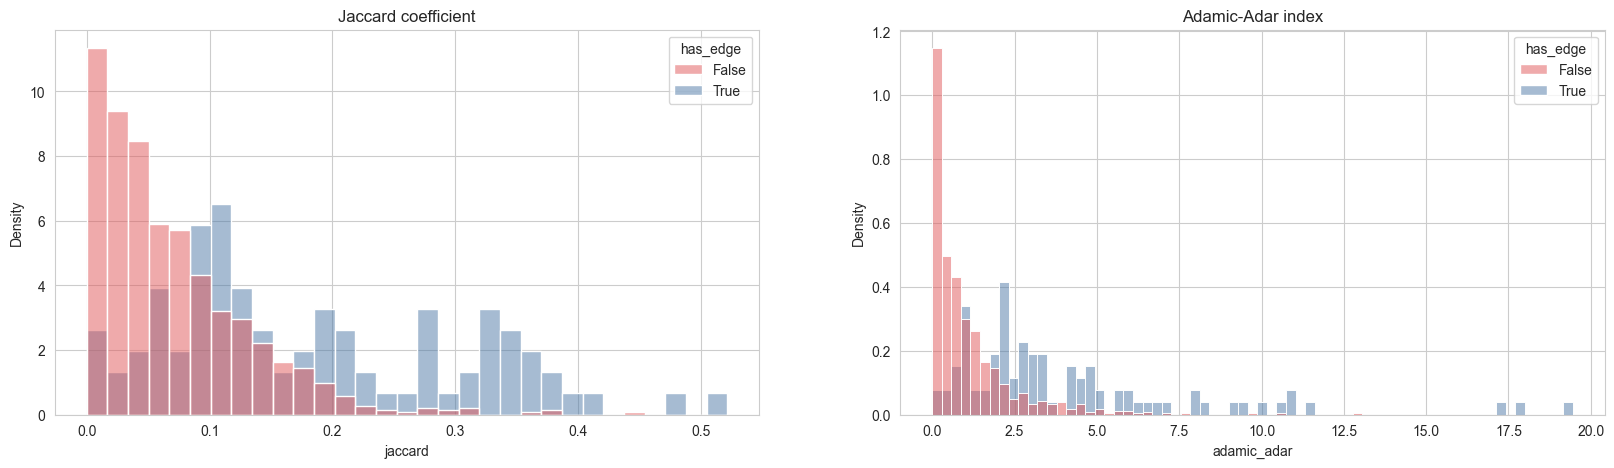

In [12]:
color_defs = {True: "#4e79a7", False: "#e15759"}
subgraph_nodes = list(g_subgraph.nodes)
data_jaccard_adamic = []

for _ in range(1000):
    u = np.random.choice(subgraph_nodes)
    v = np.random.choice(subgraph_nodes)
    if u == v:
        continue

    u_neighbors = set(g_subgraph.neighbors(u))
    v_neighbors = set(g_subgraph.neighbors(v))
    u_common_neighbors = u_neighbors.intersection(v_neighbors)
    adamic_adar_index = sum(
        1 / math.log(g_subgraph.degree(n)) for n in u_common_neighbors
    )
    jaccard_coefficient = len(u_common_neighbors) / len(u_neighbors.union(v_neighbors))
    has_edge = g_subgraph.has_edge(u, v)
    data_jaccard_adamic.append((u, v, jaccard_coefficient, adamic_adar_index, has_edge))

data_jaccard_adamic = pd.DataFrame(
    data_jaccard_adamic, columns=["u", "v", "jaccard", "adamic_adar", "has_edge"]
)
data_jaccard_adamic.u = data_jaccard_adamic.u.astype(int)
data_jaccard_adamic.v = data_jaccard_adamic.v.astype(int)

fig, axes = plt.subplots(1, 3, figsize=(20, 5), width_ratios=[2, 1, 1])
ax = axes[0]
colors = data_jaccard_adamic.has_edge.map(color_defs)

ax.scatter(
    data_jaccard_adamic.jaccard, data_jaccard_adamic.adamic_adar, c=colors, alpha=0.5
)
ax.set_xlabel("Jaccard coefficient")
ax.set_ylabel("Adamic-Adar index")

max_j = np.argmax(data_jaccard_adamic.jaccard.values)
max_a = np.argmax(data_jaccard_adamic.adamic_adar.values)
ax.plot(
    data_jaccard_adamic.iloc[max_a, 2],
    data_jaccard_adamic.iloc[max_a, 3],
    "o",
    color="C2",
    ms=20,
    mfc="none",
    label="Max Adamic-Adar",
)
ax.plot(
    data_jaccard_adamic.iloc[max_j, 2],
    data_jaccard_adamic.iloc[max_j, 3],
    "o",
    color="C1",
    ms=20,
    mfc="none",
    label="Max Jaccard",
)
ax.text(
    data_jaccard_adamic.iloc[max_a, 2],
    data_jaccard_adamic.iloc[max_a, 3],
    f"{max_a=}",
    fontsize=12,
    ha="right",
    color="C2",
)
ax.text(
    data_jaccard_adamic.iloc[max_j, 2],
    data_jaccard_adamic.iloc[max_j, 3],
    f"{max_j=}",
    fontsize=12,
    ha="right",
    color="C1",
)
draw_graphs(g_subgraph, data_jaccard_adamic, axes[1], axes[2])

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(
    data=data_jaccard_adamic,
    x="jaccard",
    hue="has_edge",
    ax=axes[0],
    stat="density",
    common_norm=False,
    palette=color_defs,
)
sns.histplot(
    data=data_jaccard_adamic,
    x="adamic_adar",
    hue="has_edge",
    ax=axes[1],
    stat="density",
    common_norm=False,
    palette=color_defs,
)
axes[0].set_title("Jaccard coefficient")
axes[1].set_title("Adamic-Adar index")

#### Preferential attachment

Preferential attachment is a measure of similarity between two nodes based on the product of their degrees. It assumes that nodes with higher degrees are more likely to form new links.

Text(0.5, 1.0, 'Preferential attachment: 1170')

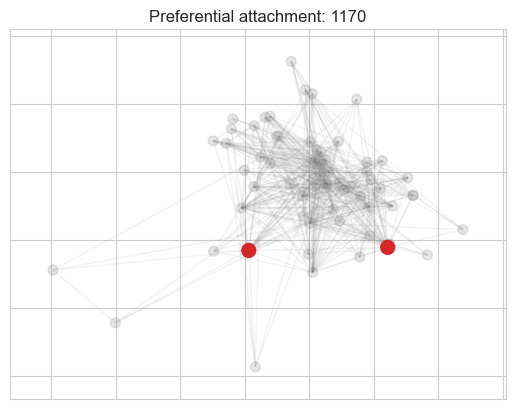

In [13]:
u = np.random.choice(subgraph_nodes)
v = np.random.choice(subgraph_nodes)

u_degree = g_subgraph.degree(u)
v_degree = g_subgraph.degree(v)
preferential_attachment = u_degree * v_degree
draw_ego_graph(
    ax=plt.gca(),
    pos=pos,
    g=g_subgraph,
    u=u,
    v=v,
    node_color_main="C3",
    edge_color_main="C3",
)
plt.title(f"Preferential attachment: {preferential_attachment}")

#### Common neighbors

The common neighbors feature is the number of common neighbors between two nodes. It is a simple measure of similarity between two nodes.


Text(0.5, 1.0, 'Common neighbors: 3')

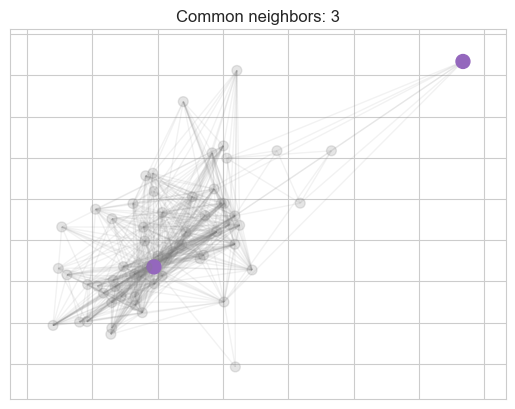

In [14]:
u = np.random.choice(subgraph_nodes)
v = np.random.choice(subgraph_nodes)
common_neighbors = len(
    set(g_subgraph.neighbors(u)).intersection(set(g_subgraph.neighbors(v)))
)
draw_ego_graph(
    ax=plt.gca(),
    pos=pos,
    g=g_subgraph,
    u=u,
    v=v,
    node_color_main="C4",
    edge_color_main="C4",
)
plt.title(f"Common neighbors: {common_neighbors}")

#### Resource allocation index
Resource allocation index is a measure of similarity between two nodes based on the number of common neighbors. It assigns more weight to rare neighbors. The resource allocation index is defined as the sum of the inverse degrees of the common neighbors.


Text(0.5, 1.0, 'Resource allocation index: 0.150')

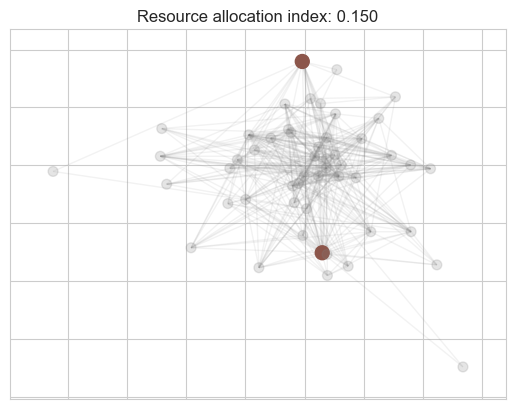

In [15]:
u = np.random.choice(subgraph_nodes)
v = np.random.choice(subgraph_nodes)

u_neighbors = set(g_subgraph.neighbors(u))
v_neighbors = set(g_subgraph.neighbors(v))
u_common_neighbors = u_neighbors.intersection(v_neighbors)
resource_allocation_index = sum(1 / g_subgraph.degree(n) for n in u_common_neighbors)
draw_ego_graph(
    ax=plt.gca(),
    pos=pos,
    g=g_subgraph,
    u=u,
    v=v,
    node_color_main="C5",
    edge_color_main="C5",
)
plt.title(f"Resource allocation index: {resource_allocation_index:.3f}")

Text(0.5, 1.0, 'Resource allocation index')

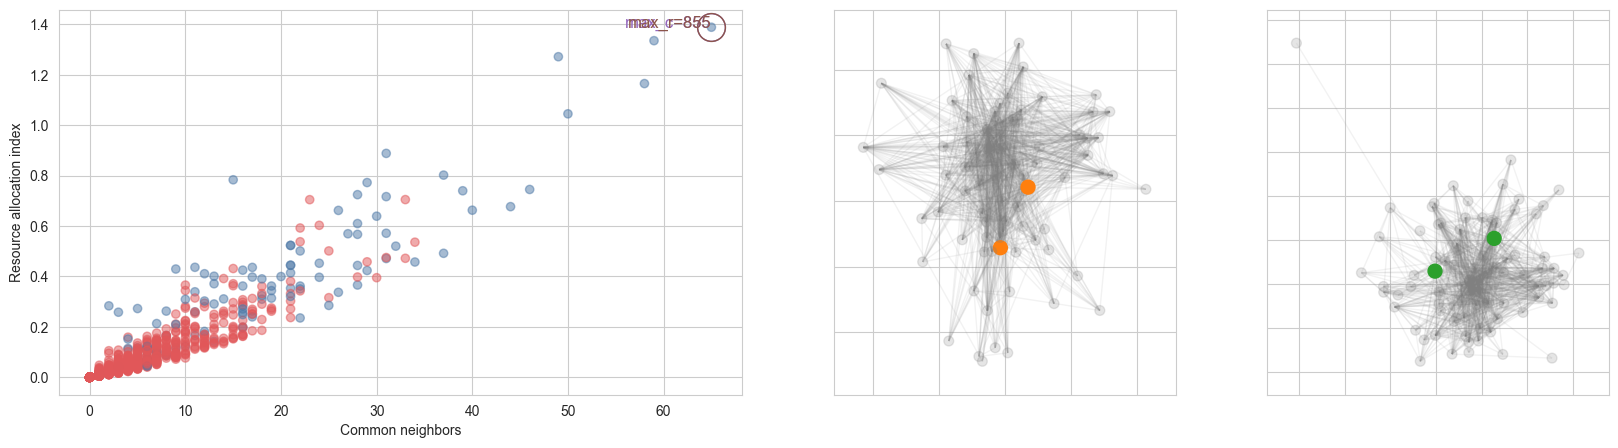

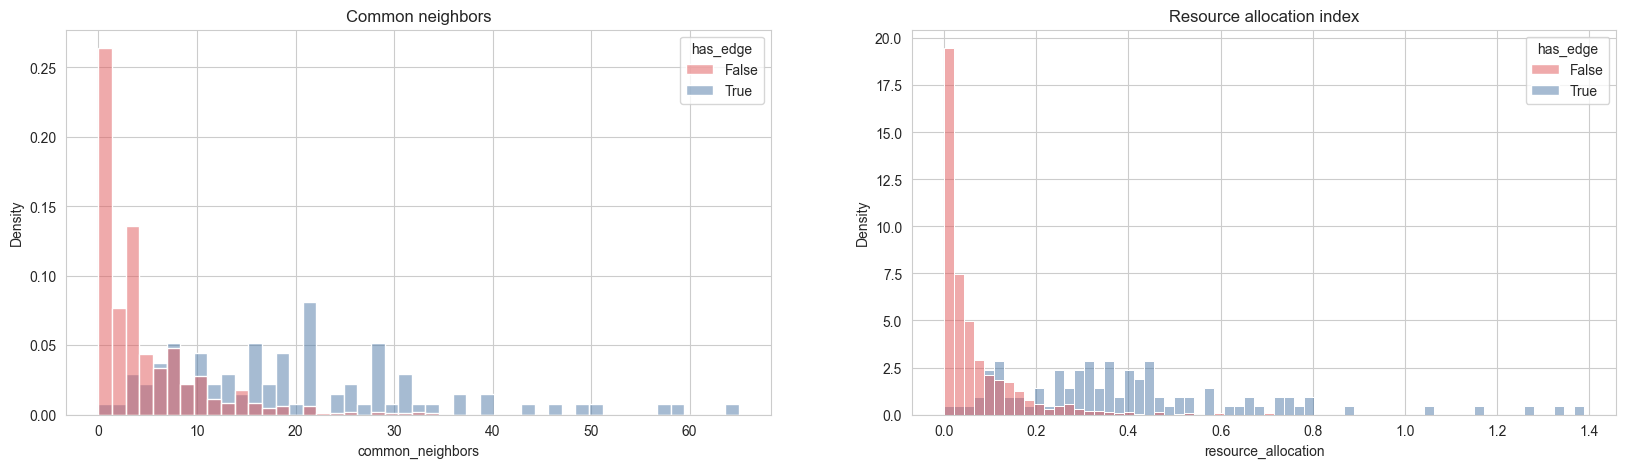

In [16]:
data_common_resource = []
for _ in range(1000):
    u = np.random.choice(subgraph_nodes)
    v = np.random.choice(subgraph_nodes)
    if u == v:
        continue

    u_neighbors = set(g_subgraph.neighbors(u))
    v_neighbors = set(g_subgraph.neighbors(v))
    u_common_neighbors = u_neighbors.intersection(v_neighbors)
    resource_allocation_index = sum(
        1 / g_subgraph.degree(n) for n in u_common_neighbors
    )
    common_neighbors = len(u_common_neighbors)
    has_edge = g_subgraph.has_edge(u, v)
    data_common_resource.append(
        (u, v, common_neighbors, resource_allocation_index, has_edge)
    )

data_common_resource = pd.DataFrame(
    data_common_resource,
    columns=["u", "v", "common_neighbors", "resource_allocation", "has_edge"],
)
data_common_resource.u = data_common_resource.u.astype(int)
data_common_resource.v = data_common_resource.v.astype(int)

fig, axes = plt.subplots(1, 3, figsize=(20, 5), width_ratios=[2, 1, 1])
ax = axes[0]
colors = data_common_resource.has_edge.map(color_defs)
ax.scatter(
    data_common_resource.common_neighbors,
    data_common_resource.resource_allocation,
    c=colors,
    alpha=0.5,
)
ax.set_xlabel("Common neighbors")
ax.set_ylabel("Resource allocation index")

max_c = np.argmax(data_common_resource.common_neighbors.values)
max_r = np.argmax(data_common_resource.resource_allocation.values)
ax.plot(
    data_common_resource.iloc[max_c, 2],
    data_common_resource.iloc[max_c, 3],
    "o",
    color="C4",
    ms=20,
    mfc="none",
    label="Max Common neighbors",
)
ax.plot(
    data_common_resource.iloc[max_r, 2],
    data_common_resource.iloc[max_r, 3],
    "o",
    color="C5",
    ms=20,
    mfc="none",
    label="Max Resource allocation",
)
ax.text(
    data_common_resource.iloc[max_c, 2],
    data_common_resource.iloc[max_c, 3],
    f"{max_c=}",
    fontsize=12,
    ha="right",
    color="C4",
)
ax.text(
    data_common_resource.iloc[max_r, 2],
    data_common_resource.iloc[max_r, 3],
    f"{max_r=}",
    fontsize=12,
    ha="right",
    color="C5",
)

draw_graphs(g_subgraph, data_common_resource, axes[1], axes[2])

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(
    data=data_common_resource,
    x="common_neighbors",
    hue="has_edge",
    ax=axes[0],
    stat="density",
    common_norm=False,
    palette=color_defs,
)
sns.histplot(
    data=data_common_resource,
    x="resource_allocation",
    hue="has_edge",
    ax=axes[1],
    stat="density",
    common_norm=False,
    palette=color_defs,
)
axes[0].set_title("Common neighbors")
axes[1].set_title("Resource allocation index")

#### Ready-to-use functions for link prediction

Fortunately, `networkx` provides built-in functions for calculating the link prediction features we discussed above. We can use these functions to calculate the features for all pairs of nodes in the social graph. Below are histograms of the link prediction features for pairs of nodes with and without edges.

In [17]:
data = []
for _ in range(1000):
    u = np.random.choice(subgraph_nodes)
    v = np.random.choice(subgraph_nodes)
    has_edge = g_subgraph.has_edge(u, v)
    jaccard_coefficient = nx.jaccard_coefficient(g_subgraph, [(u, v)])
    adamic_adar_index = nx.adamic_adar_index(g_subgraph, [(u, v)])
    preferential_attachment = nx.preferential_attachment(g_subgraph, [(u, v)])
    common_neighbors = nx.common_neighbors(g_subgraph, u, v)
    resource_allocation_index = nx.resource_allocation_index(g_subgraph, [(u, v)])
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "jaccard_coefficient",
            "metric_value": list(jaccard_coefficient)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "adamic_adar_index",
            "metric_value": list(adamic_adar_index)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "preferential_attachment",
            "metric_value": list(preferential_attachment)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "common_neighbors",
            "metric_value": len(list(common_neighbors)),
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "resource_allocation_index",
            "metric_value": list(resource_allocation_index)[0][-1],
        }
    )

df_metrics = pd.DataFrame(data)

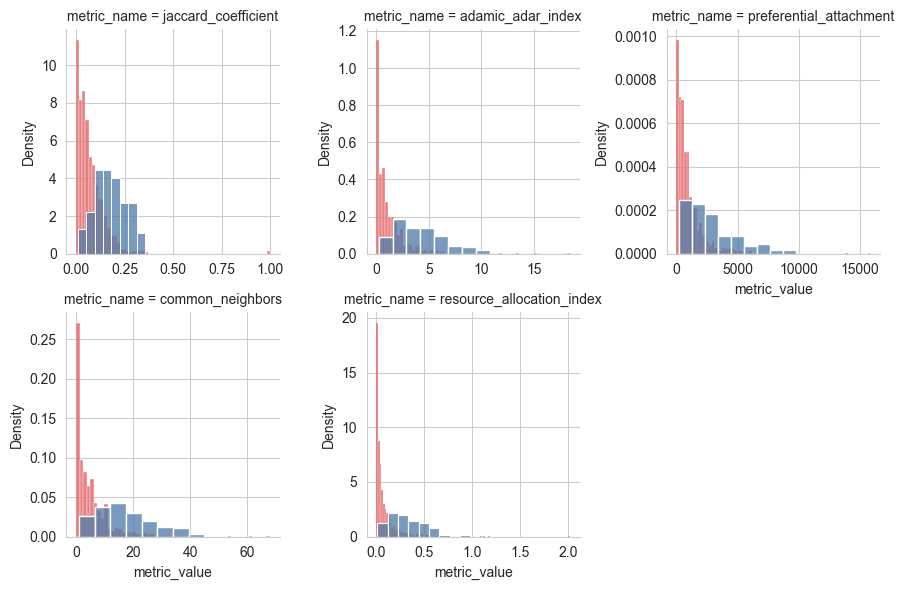

In [18]:
g = sns.FacetGrid(
    df_metrics,
    col="metric_name",
    hue="has_edge",
    col_wrap=3,
    sharex=False,
    sharey=False,
    palette=color_defs,
)
g.map(sns.histplot, "metric_value", stat="density", common_norm=False)

We can clearly see that the link prediction features are different for pairs of nodes with and without edges. This suggests that the features can be used to predict links in the network.

### Combining features

In [19]:
df_x = df_metrics.pivot_table(
    index=["u", "v"], columns="metric_name", values="metric_value"
).reset_index()
combined_x = []
for _, row in df_x.iterrows():
    u = row["u"]
    v = row["v"]
    if u > v:
        u, v = v, u
    x_v = df_triad_metrics.loc[v].add_prefix("v_")
    x_u = df_triad_metrics.loc[u].add_prefix("u_")
    combined_x.append(pd.concat([row, x_v, x_u]))
combined_x = pd.DataFrame(combined_x)
df_combined = pd.DataFrame(combined_x)
# for i in range(1, 4):
#     df_combined[f'rand_{i}'] = np.random.rand(df_combined.shape[0])
df_combined

,u,v,adamic_adar_index,common_neighbors,jaccard_coefficient,preferential_attachment,resource_allocation_index,v_clustering_coefficient,v_closed_triads,v_open_triads,...,v_triad_Single edge,"v_triad_Two edges forming a ""V""",v_triad_Full triad,u_clustering_coefficient,u_closed_triads,u_open_triads,u_triad_No edges,u_triad_Single edge,"u_triad_Two edges forming a ""V""",u_triad_Full triad
0,2.0,134.0,3.040837,11.0,0.111111,2904.0,0.339191,0.173362,164.0,2210.0,...,45053.0,2992.0,164.0,0.110744,804.0,4227.0,287991.0,96127.0,10683.0,804.0
1,2.0,165.0,4.062654,14.0,0.137255,3300.0,0.482389,0.303673,372.0,1554.0,...,50927.0,2407.0,372.0,0.110744,804.0,4227.0,287991.0,96127.0,10683.0,804.0
2,2.0,231.0,5.126400,20.0,0.202020,3498.0,0.445846,0.208529,533.0,3086.0,...,64576.0,5109.0,533.0,0.110744,804.0,4227.0,287991.0,96127.0,10683.0,804.0
3,2.0,607.0,8.658057,34.0,0.201183,9042.0,0.713661,0.176099,2620.0,5266.0,...,123173.0,17524.0,2620.0,0.110744,804.0,4227.0,287991.0,96127.0,10683.0,804.0
4,2.0,706.0,0.646970,2.0,0.027397,594.0,0.092157,0.475000,57.0,741.0,...,24886.0,804.0,57.0,0.110744,804.0,4227.0,287991.0,96127.0,10683.0,804.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,997.0,1003.0,1.281061,6.0,0.153846,494.0,0.056416,0.380117,65.0,1406.0,...,26110.0,1512.0,65.0,0.466667,203.0,2557.0,359703.0,32910.0,2789.0,203.0
994,999.0,381.0,0.000000,0.0,0.000000,95.0,0.000000,0.476190,10.0,340.0,...,17941.0,351.0,10.0,0.349945,316.0,2060.0,348243.0,44399.0,2647.0,316.0
995,1003.0,196.0,2.718390,10.0,0.196078,798.0,0.287078,0.380117,65.0,1406.0,...,26110.0,1512.0,65.0,0.270616,233.0,2333.0,349279.0,43132.0,2961.0,233.0
996,1003.0,318.0,0.207457,1.0,0.027027,361.0,0.008065,0.380117,65.0,1406.0,...,26110.0,1512.0,65.0,0.234818,174.0,1489.0,350920.0,42455.0,2056.0,174.0


In [20]:
X = df_combined.drop(columns=["u", "v"])
y = np.array(
    [
        social_graph_before.has_edge(int(row.u), int(row.v))
        for _, row in df_combined.iterrows()
    ]
)
weight = np.array([1 if has_edge else 0.05 for has_edge in y])

In [21]:
X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.2, random_state=42
)

In [22]:
model = CatBoostClassifier(
    n_estimators=1000,
    learning_rate=0.001,
    depth=12,
    eval_metric="AUC",
    loss_function="Logloss",
    l2_leaf_reg=4,
    verbose=False,
)
model.fit(
    X_train,
    y_train,
    sample_weight=weight_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=150,
    plot=True,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<Axes: title={'center': 'Feature importance'}>

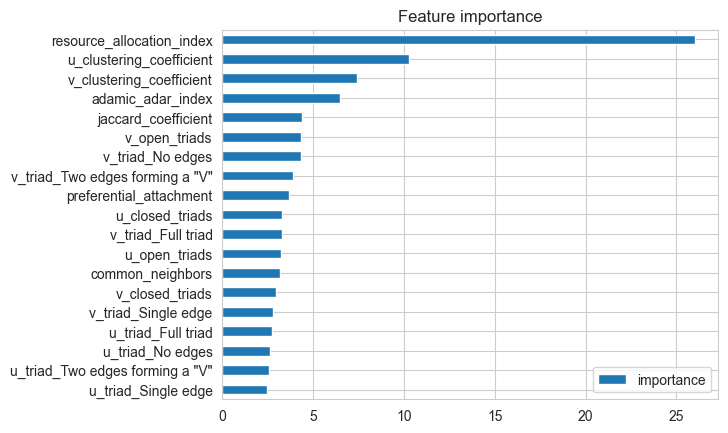

In [23]:
feature_importance = (
    pd.DataFrame(
        model.get_feature_importance(), index=X.columns, columns=["importance"]
    )
    .sort_values("importance", ascending=True)
    .tail(30)
)
feature_importance.plot(kind="barh", title="Feature importance")

Now, that we have a model, we can sample node pairs from the graph, predict whether a link exists between them, and compare the predictions with the actual links. 

In [24]:
newly_added_edges.groupby("source").size().sort_values(ascending=False).head(10)

source
229    53
2      43
75     41
90     39
53     34
120    29
91     27
362    27
293    26
214    25
dtype: int64

In [39]:
def check_prediction(source_node, cutoff=0.5):
    newly_added_edges_to_source = newly_added_edges[newly_added_edges.source == source_node]
    n_added = newly_added_edges_to_source.shape[0]
    print(
        f"The node {source_node} has {n_added:,} new neighbors."
    )
    if not n_added:
        return
    to_predict_x = []
    to_predict_y = []
    for target in social_graph_before.nodes():
        if target == source_node:
            continue
        if source_node > target:
            u, v = target, source_node
        else:
            u, v = source_node, target
    
        x_v = df_triad_metrics.loc[v].add_prefix("v_")
        x_u = df_triad_metrics.loc[u].add_prefix("u_")
        jaccard_coefficient = nx.jaccard_coefficient(social_graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(social_graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(social_graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(social_graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(
            social_graph_before, [(u, v)]
        )
        x_other = pd.Series(
            {
                "adamic_adar_index": list(adamic_adar_index)[0][-1],
                "common_neighbors": len(list(common_neighbors)),
                "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
                "preferential_attachment": list(preferential_attachment)[0][-1],
                
                "resource_allocation_index": list(resource_allocation_index)[0][-1],
            }
        )
        x = pd.concat([x_other, x_v, x_u])
        to_predict_x.append(x)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges.source == source_node)
                & (newly_added_edges.target == target)
            ].shape[0]
            > 0
        )
    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    
    
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(ncols=2)
    ax = axes[0]
    ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_aspect("equal")
    ax = axes[1]
    venn2(
        subsets=(set(np.where(observed)[0]), set(np.where(predicted)[0])),
        set_labels=("Observed", "Predicted"),
        ax=ax,
    )
    fig.suptitle(f"Source node {source_node}: AUC={roc_auc:.2f}")    

The node 229 has 53 new neighbors.


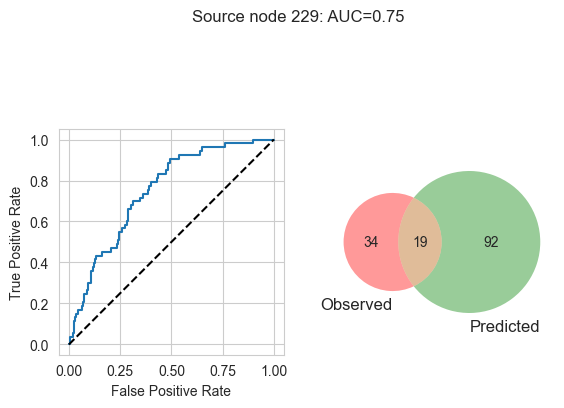

In [41]:
check_prediction(229)

The node 898 has 2 new neighbors.


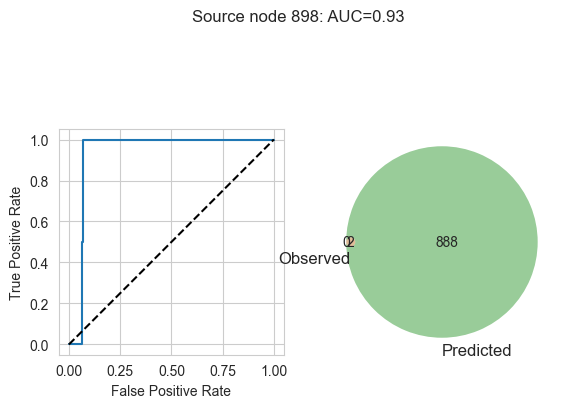

In [45]:
check_prediction(898, 0.4)

The node 61 has 21 new neighbors.


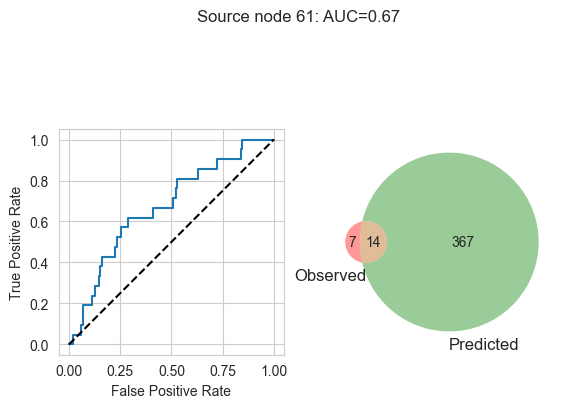

In [52]:
check_prediction(np.random.choice(social_graph_before.nodes()))